<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Visión por Computadora</center></span>
## <span style="color:red"><center>Segmentación Semántica</center></span>

##   <span style="color:blue">Profesores</span>

### Coordinador


- Campo Elías Pardo Turriago, cepardot@unal.edu.co 

### Conferencistas


- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

## <span style="color:blue">Asesora Medios y Marketing digital</span>

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 



## <span style="color:blue">Asistentes</span>



- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

## <span style="color:blue">Introducción</span>

Se han mostrado las tareas de clasificación y detección desde un punto muy sencillo, donde damos la imagen y la red nos entrega la clase sin detalle, hasta detectar partes específicas de un cuerpo humano. En estas tareas se han hecho grandes esfuerzos en detectar únicamente "lo importante", buscando optimizar las regiones en las que tenemos clases. Pero, podemos hacer modelos que hagan una detección "Completa", clasificando cada pixel de la imagen. Esto es la Segmentación Semántica.

## <span style="color:blue">Clasificación de Pixeles</span>

Ya hemos visto un acercamiento a la segmentación cuando se mostró la segmentación por instancia en la [estimación de poses](../Cuadernos/estimacion_poses.ipynb), y de hecho toma técnicas similares. La diferencia entre estas es cómo trata a las clases a buscar.

- Instancia: Trata diferentes objetos de la misma clase como sus propias entidades
- Semántica: Los objetos que comparten tipo de clase son parte de una misma entidad

<figure>
<center>
<img src="../Imagenes/semantic-instance.jpg" width="800" height="319" align="center"/> 
</center>
</figure>

El fin de esta tarea es la siguiente: obtener un "mapa de segmentación", donde cada pixel tendrá un número entero referente a las clases a separar.

<figure>
<center>
<img src="../Imagenes/semantic1.png" width="700" height="250" align="center"/> 
</center>
</figure>

Esto se logra haciendo un one-hot enconding sobre cada clase

<figure>
<center>
<img src="../Imagenes/semantic2.png" width="500" height="250" align="center"/> 
</center>
</figure>

## <span style="color:blue">Estructura U-Net</span>

Como la segmentación semántica es, en su forma más elemental, un problema de clasificación, los primeros intentos para crear redes de segmentación fueron usando estructuras más "clásicas" de redes Completamente convolucionales

<figure>
<center>
<img src="../Imagenes/FCN_classic.png" width="580" height="250" align="center"/> 
</center>
</figure>

El problema yace en la escala del problema. en la clasificación clásica, realmente no nos importan los detalles, sino la obtención de características generales. En la segmentación semántica los detalles son muy importantes, por lo que cada pixel cuenta. Por esa razón, tenemos que mantener la resolución original, cosa que es computacionalmente costoso. 

La primera respuesta a esto fue aplicar una estructura de codificación y decodificación, similar a [DCGANs](../Cuadernos/DCGAN.ipynb) y [Autoencoders](../../Autocodificadores/Cuadernos/ae_Example_Dense_mnist.ipynb). Permitiendo reducir la imagen, reduciendo recursos, mientras obtenemos mapas de características de baja resolución que luego podemos aumentar al tamaño original.

<figure>
<center>
<img src="../Imagenes/FCN.png" width="1400" height="350" align="center"/> 
</center>
</figure>

Esto tiene resultados..........aceptables. Por lo que hay que seguir mejorando

<figure>
<center>
<img src="../Imagenes/FCN_example.png" align="center"/> 
</center>
</figure>

Aquí entra al juego U-Net(llamado así por razones que serán obvias pronto), que introduce el uso de conexiones de salto al estilo [ResNet](../Cuadernos/redes_residuales.ipynb) con las redes "equivalentes" entre los bloques de codificación y decodificación, concatenando las imagenes originales de mayor resolución con las ampliadas. 

<figure>
<center>
<img src="../Imagenes/unet.png" width="700" height="500" align="center"/> 
</center>
</figure>

Esto permite corregir los pequeños detalles de las imagenes. Obteniendo resultados mucho mejores

<figure>
<center>
<img src="../Imagenes/unet_example.png" align="center"/> 
</center>
</figure>

Ya han habido mejoras a esta arquitectura, particularmente el uso de [Bloques Densos](../Cuadernos/clasificacion_moderna.ipynb). Pero aquí no está el estado del arte. Es necesario pasar a otros intentos de mejorar el modelo clásico

## <span style="color:blue">Google DeepLab</span>

Esta arquitectura nos ofrece dos innovaciones importantes

### <span style="color:blue">Convoluciones dilatadas</span>

en el modelo clásico, con cada convolución que se hace, se tiende a reducir tamaño de salida, así que se pierde mucha información pequeña. Aquí es donde se introduce la "Convolución Dilatada", con la intención de extraer características densas mientras se preserva la escala de la imagen. Esta convolución introduce el nuevo parámetro "$r$" o la rata de dilatación, que indica que se agregan $r-1$ ceros entre dos valores consecutivos del filtro. LA itnención de esta nueva convolución es tener flexibilidad para modificar el campo de visión del filtro sin tener que aprender nuevos parámetros

<figure>
<center>
<img src="../Imagenes/atrous.gif" align="center"/> 
</center>
</figure>

Aplicando estas convoluciones, podemos mantener el tamaño de la imagen mientras se sigue procesando

<figure>
<center>
<img src="../Imagenes/atrous_net.png" align="center"/> 
</center>
</figure>

### <span style="color:blue">Bloques piramidales</span>

Llamado realmente como el "método de red piramidal". Definimos un bloque con un parámetro vectorial de múltiples ratas de dilatación $(r_1, r_2, r_3)$, y se aplican tres convoluciones con cada una de estas, en forma de cascada.

<figure>
<center>
<img src="../Imagenes/pyramid_block.png" align="center"/> 
</center>
</figure>

La estructura se reduce de la siguiente forma:

- Se hace extracción clásica de características con un backbone tradicional
- Se controla el tamaño de los mapas de características usando una convolución dilatada en los últimos bloques del backbone
- Estos mapas pasan por una red de bloques piramidales para clasificar cada pequeño pixel
- Se pasa el resultado por una convolución 1x1 para obtener el tamaño correcto

<figure>
<center>
<img src="../Imagenes/deeplab.png" align="center"/> 
</center>
</figure>

Vamos a hacer una comparativa con una red completamente convolucional y DeeplabV3

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import datetime

In [2]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

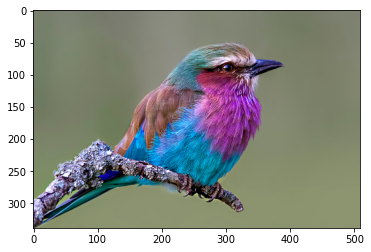

In [3]:
import cv2
import matplotlib.pyplot as plt
import torch

img = cv2.imread("../Imagenes/bird.jpg")
plt.imshow(img[:,:,::-1]); plt.show()

In [6]:
import torchvision.transforms as T
trf = T.Compose([T.ToPILImage(),
                 T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).to('cuda').unsqueeze(0)



In [7]:
out = fcn.to('cuda')(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [8]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


In [9]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

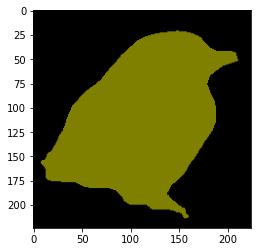

In [10]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

torch.cuda.empty_cache()

In [18]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = cv2.imread(path)
  if show_orig: plt.imshow(img[:,:,::-1]); plt.show()
  trf = T.Compose([T.ToPILImage(),
                   T.Resize(256), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

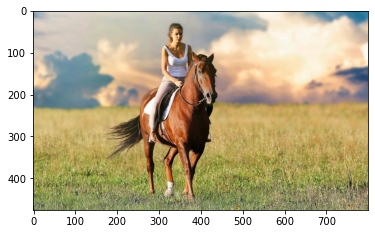

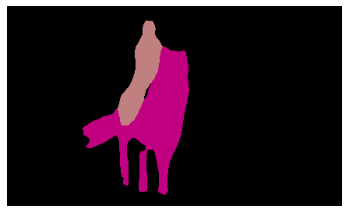

In [16]:
segment(fcn, "../Imagenes/Horse-riding.jpg")

In [13]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/thejarmanitor/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

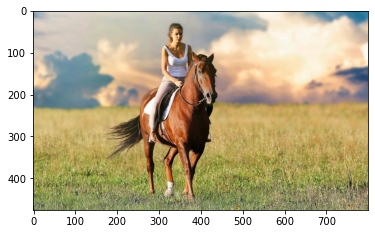

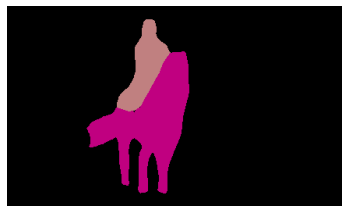

In [17]:
segment(dlab, "../Imagenes/Horse-riding.jpg")